In [1]:
%matplotlib inline

import re

import pandas as pd
import numpy as np

from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE

from matplotlib import pyplot as plt

PATH_TO_DATA = 'data/' 

In [2]:
train_df = pd.read_csv(PATH_TO_DATA+'train.csv', index_col='PassengerId')
test_df = pd.read_csv(PATH_TO_DATA+'test.csv', index_col='PassengerId')

In [3]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Missing values

In [4]:
print('Train:')
print(train_df[train_df.columns[1:]].describe())
print()
print('Test:')
print(test_df.describe())

Train:
           Pclass         Age       SibSp       Parch        Fare
count  891.000000  714.000000  891.000000  891.000000  891.000000
mean     2.308642   29.699118    0.523008    0.381594   32.204208
std      0.836071   14.526497    1.102743    0.806057   49.693429
min      1.000000    0.420000    0.000000    0.000000    0.000000
25%      2.000000   20.125000    0.000000    0.000000    7.910400
50%      3.000000   28.000000    0.000000    0.000000   14.454200
75%      3.000000   38.000000    1.000000    0.000000   31.000000
max      3.000000   80.000000    8.000000    6.000000  512.329200

Test:
           Pclass         Age       SibSp       Parch        Fare
count  418.000000  332.000000  418.000000  418.000000  417.000000
mean     2.265550   30.272590    0.447368    0.392344   35.627188
std      0.841838   14.181209    0.896760    0.981429   55.907576
min      1.000000    0.170000    0.000000    0.000000    0.000000
25%      1.000000   21.000000    0.000000    0.000000    7.895

In [5]:
train_size = train_df.shape[0]
test_size = test_df.shape[0]

train_counts = train_df.count()
test_counts = test_df.count()

train_missing_columns = [c for c in train_df.columns if train_counts[c] < train_size]
test_missing_columns = [c for c in test_df.columns if test_counts[c] < test_size]

print('Train:')
print('Size=%d' % train_size)
print()
print(train_df[train_missing_columns].count())
print()
print('Test:')
print('Size=%d' % test_size)
print()
print(test_df[test_missing_columns].count())

Train:
Size=891

Age         714
Cabin       204
Embarked    889
dtype: int64

Test:
Size=418

Age      332
Fare     417
Cabin     91
dtype: int64


Columns which are required attention:
 * Age
 * Cabin

### Age

In [6]:
def titul(f_df, df):
    pattern = re.compile(', \w+ ?(\w+)', re.IGNORECASE)
    def titul_extraction(name):
        finder = pattern.search(name)
        if finder:
            return finder.group()[2:]
        else:
            return 'Other'
        
    f_df['Titul'] = df['Name'].map(titul_extraction)

In [7]:
age_df = train_df.loc[train_df['Age'].notnull(), ['Name', 'Age']] \
.append(test_df.loc[test_df['Age'].notnull(), ['Name', 'Age']])

titul(age_df, age_df)

age_df.groupby('Titul')['Age'].median().to_csv(PATH_TO_DATA + 'age_means.csv')

### Cabin
Will be filled during preprocessing

### Embarked

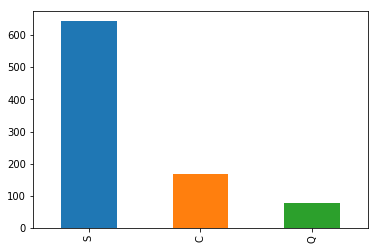

In [8]:
_ = train_df['Embarked'].value_counts().plot(kind='bar')

# Feature visualization

In [9]:
def drow_pie(col, data=train_df, pies_per_col=3):
    uniq = data[data[col].notnull()][col].unique()
    cols = pies_per_col
    rows = len(uniq) // cols + 1
    fig= plt.figure(figsize=(15, 5 * rows))
    
    for n, s in enumerate(sorted(uniq)):
        fig.add_subplot(rows, cols, n + 1)
        data[data[col] == s]['Survived'].value_counts(sort=False).plot(kind='pie', title=s)

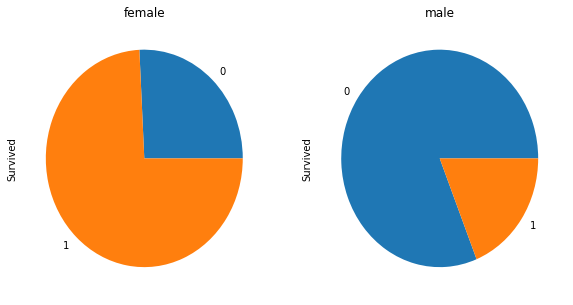

In [10]:
drow_pie('Sex')

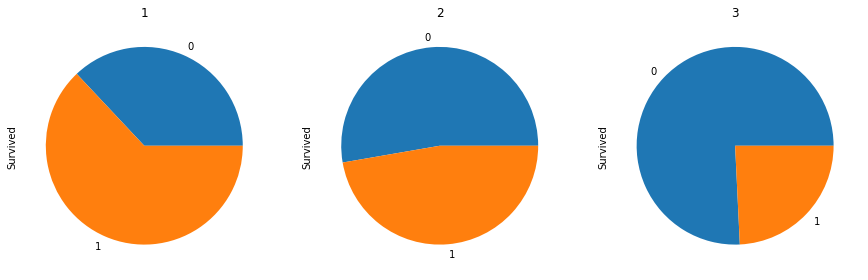

In [11]:
drow_pie('Pclass')

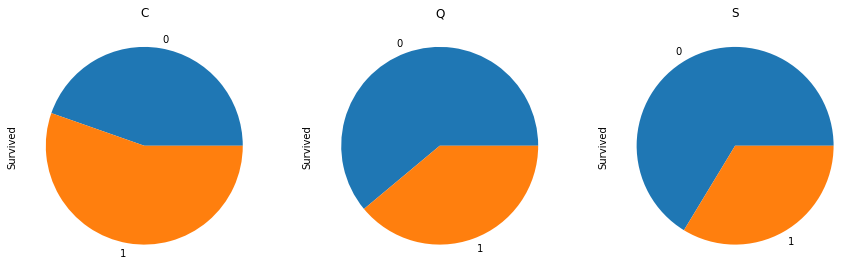

In [12]:
drow_pie('Embarked')

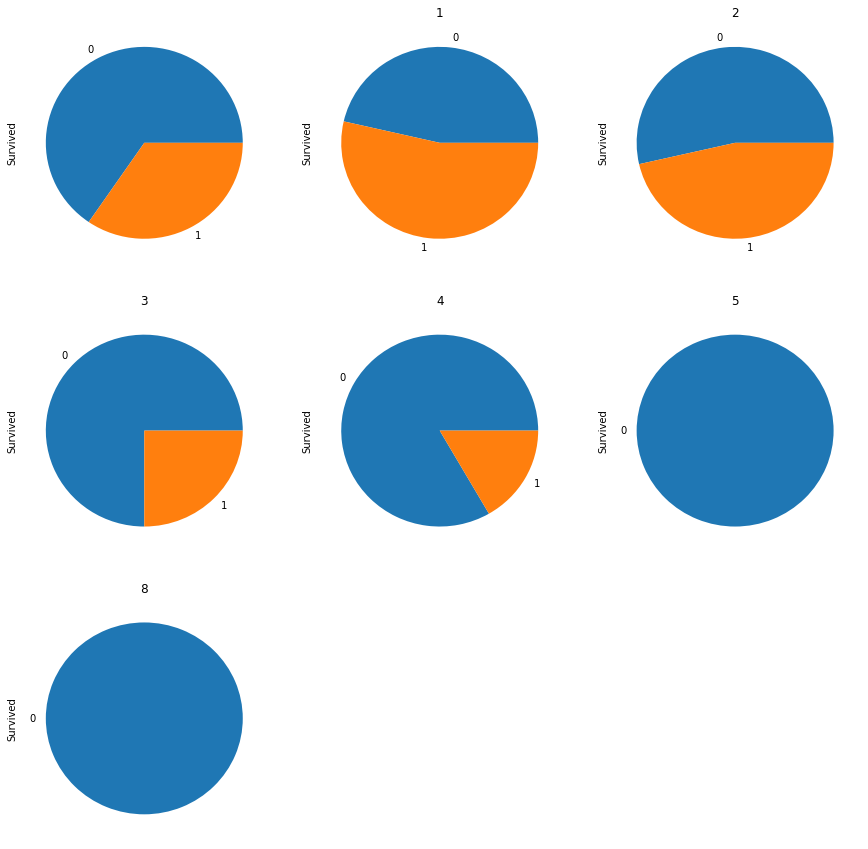

In [13]:
drow_pie('SibSp')

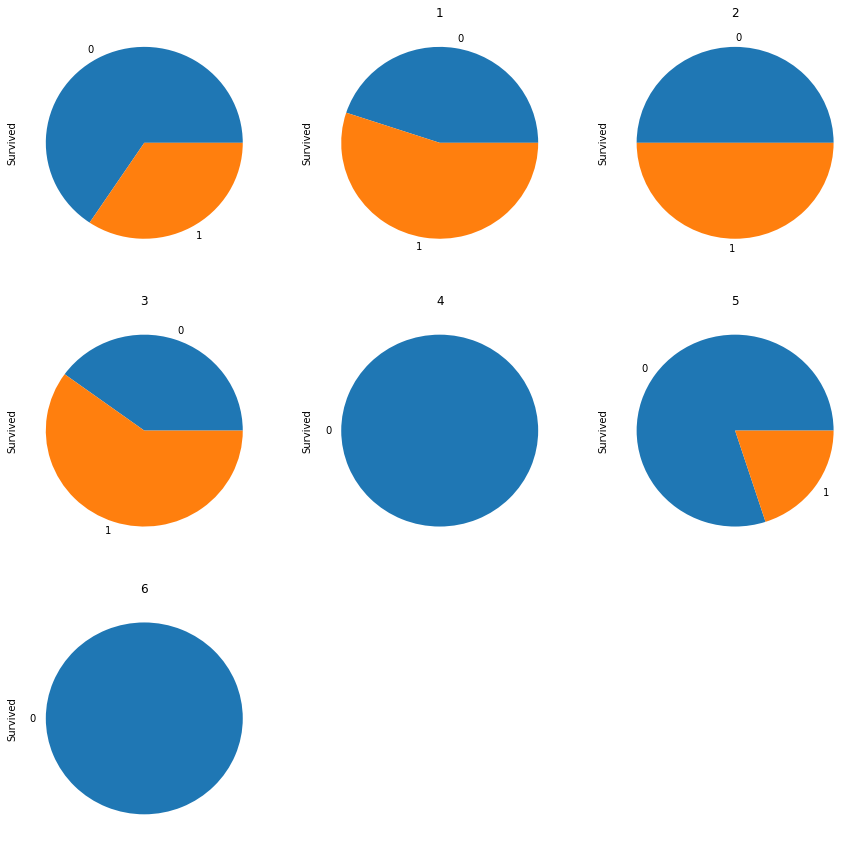

In [14]:
drow_pie('Parch')

In [15]:
def surname(f_df, df):
    counts = pd.read_csv(PATH_TO_DATA + 'surname_counts.csv', header=None, index_col=0)[1]
    def surname_extraction(name):
        pattern = re.compile('^[A-Za-z\']*', re.IGNORECASE)
        finder = pattern.search(name)
        if finder:
            return finder.group()
        else:
            print(name)
            return 'Other'
        
    f_df['Surname'] = df['Name'].map(surname_extraction)

In [16]:
titul(train_df, train_df)
surname(train_df, train_df)

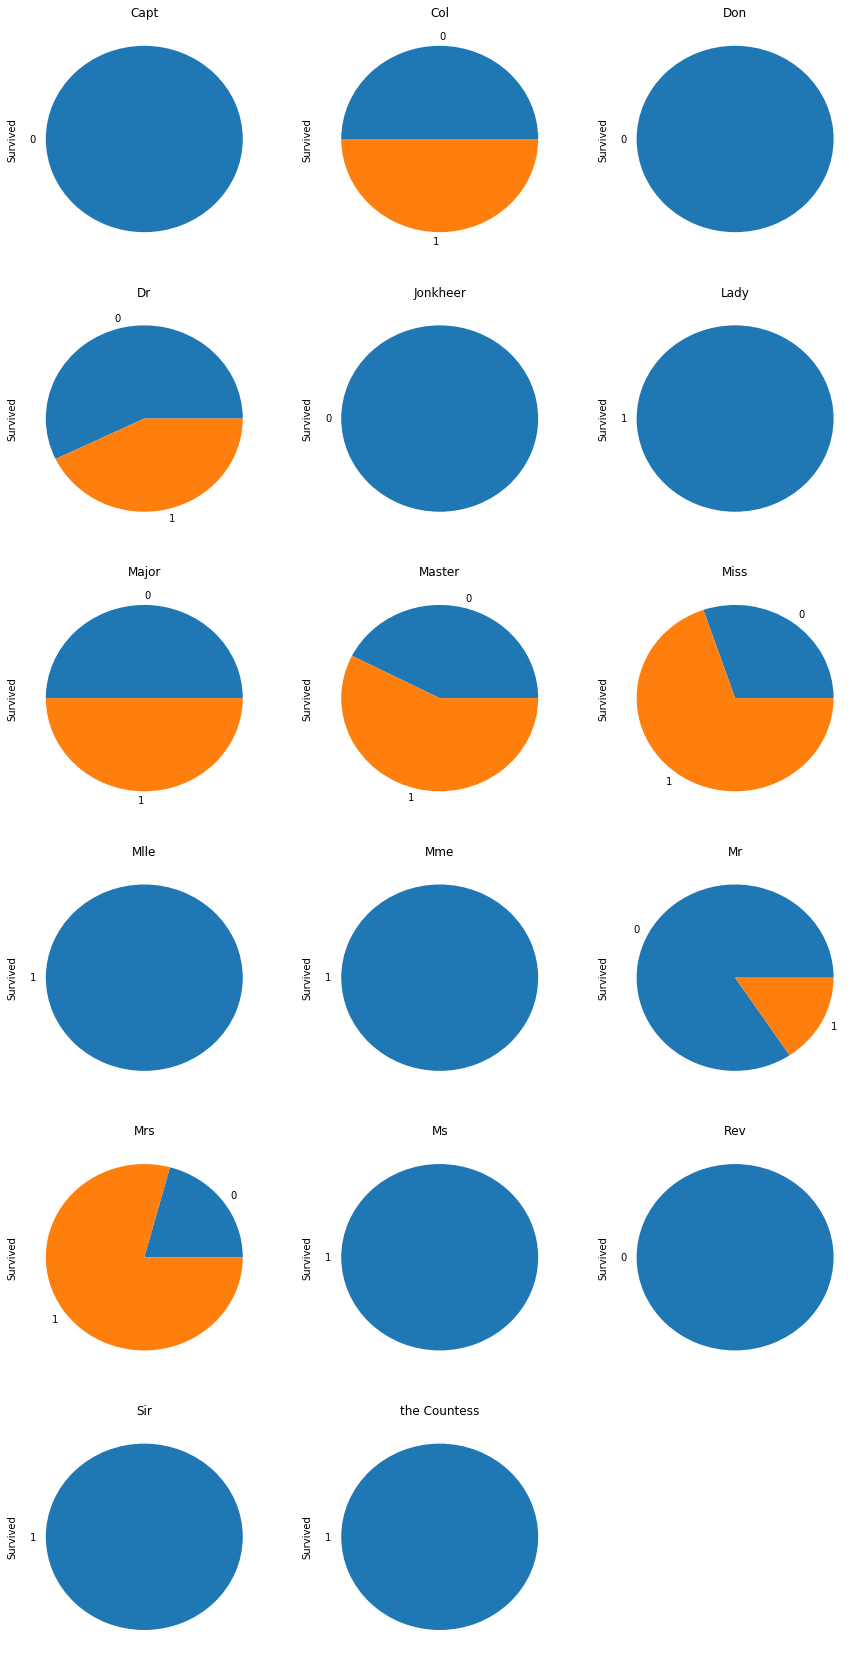

In [17]:
drow_pie('Titul')

In [18]:
wifes = train_df[train_df['Titul'] == 'Mrs']
husbands = train_df[train_df['Titul'] == 'Mr']

wifes_died = wifes[wifes['Survived'] == 0]['Surname'].unique()
wifes_survived = wifes[wifes['Survived'] == 1]['Surname'].unique()

husbands_died = husbands[husbands['Survived'] == 0]['Surname'].unique()
husbands_survived = husbands[husbands['Survived'] == 1]['Surname'].unique()

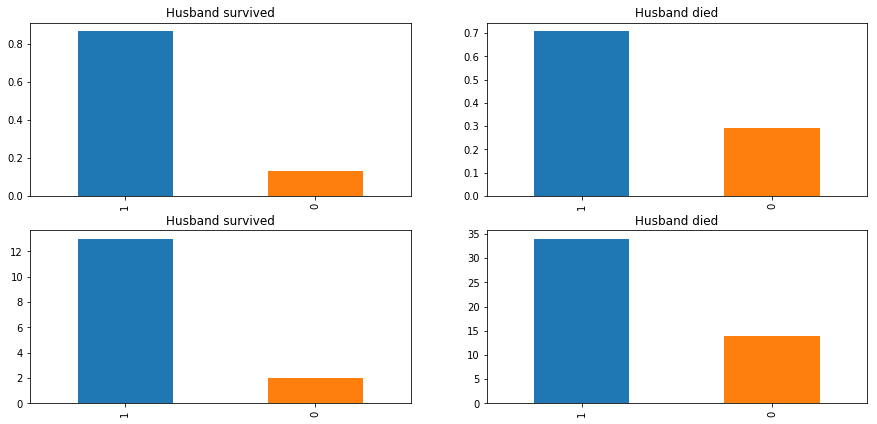

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(15,7))

_ = wifes[wifes['Surname'].isin(husbands_survived)]['Survived'].value_counts(normalize=True).plot(kind='bar', title='Husband survived', ax = ax[0][0])
_ = wifes[wifes['Surname'].isin(husbands_died)]['Survived'].value_counts(normalize=True).plot(kind='bar', title='Husband died', ax = ax[0][1])

_ = wifes[wifes['Surname'].isin(husbands_survived)]['Survived'].value_counts().plot(kind='bar', title='Husband survived', ax = ax[1][0])
_ = wifes[wifes['Surname'].isin(husbands_died)]['Survived'].value_counts().plot(kind='bar', title='Husband died', ax = ax[1][1])

Seems like if a husband died a woman has less probability to survive

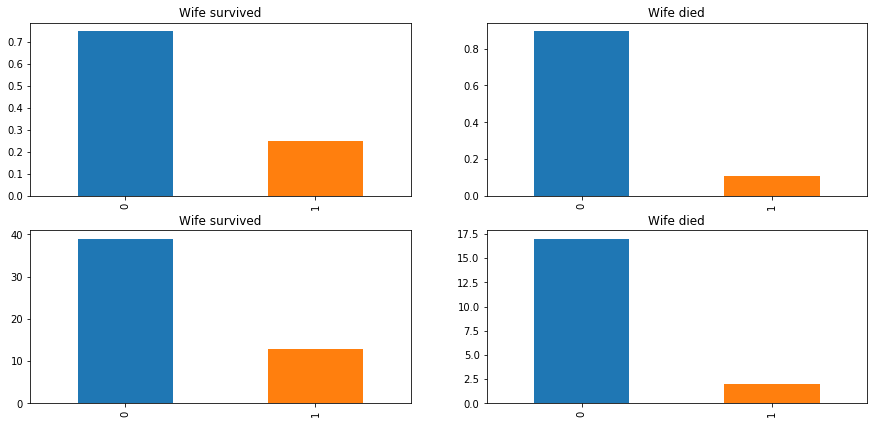

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(15,7))

_ = husbands[husbands['Surname'].isin(wifes_survived)]['Survived'].value_counts(normalize=True).plot(kind='bar', title='Wife survived', ax = ax[0][0])
_ = husbands[husbands['Surname'].isin(wifes_died)]['Survived'].value_counts(normalize=True).plot(kind='bar', title='Wife died', ax = ax[0][1])

_ = husbands[husbands['Surname'].isin(wifes_survived)]['Survived'].value_counts().plot(kind='bar', title='Wife survived', ax = ax[1][0])
_ = husbands[husbands['Surname'].isin(wifes_died)]['Survived'].value_counts().plot(kind='bar', title='Wife died', ax = ax[1][1])

Seems like if a wife died a man has much low probability to survive

In [21]:
children = train_df[train_df['Age'] < 16.]

children_died = children[children['Survived'] == 0]['Surname'].unique()
children_survived = children[children['Survived'] == 1]['Surname'].unique()

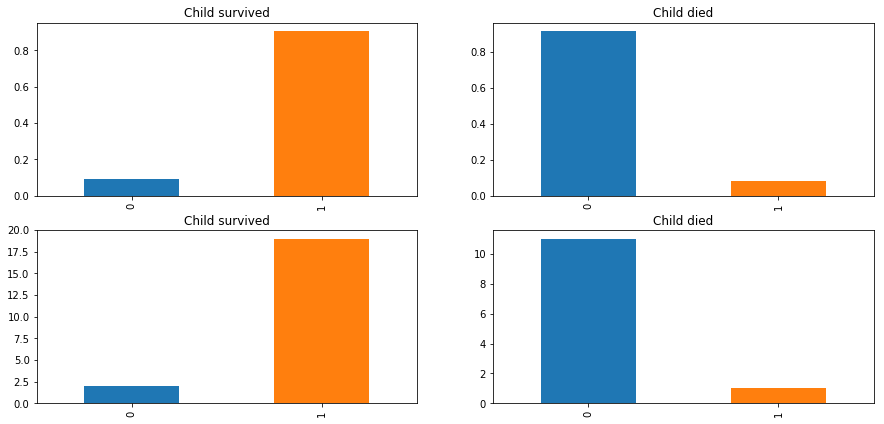

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(15,7))

_ = wifes[wifes['Surname'].isin(children_survived)]['Survived'].value_counts(normalize=True, sort=False).plot(kind='bar', title='Child survived', ax = ax[0][0])
_ = wifes[wifes['Surname'].isin(children_died)]['Survived'].value_counts(normalize=True, sort=False).plot(kind='bar', title='Child died', ax = ax[0][1])

_ = wifes[wifes['Surname'].isin(children_survived)]['Survived'].value_counts(sort=False).plot(kind='bar', title='Child survived', ax = ax[1][0])
_ = wifes[wifes['Surname'].isin(children_died)]['Survived'].value_counts(sort=False).plot(kind='bar', title='Child died', ax = ax[1][1])

If a child died a woman has very unlikely to survived

In [23]:
wifes[['Surname', 'Survived']].to_csv(PATH_TO_DATA + 'wifes.csv')
husbands[['Surname', 'Survived']].to_csv(PATH_TO_DATA + 'husbands.csv')
children[['Surname', 'Survived']].to_csv(PATH_TO_DATA + 'children.csv')

In [24]:
train_df['Cabin is present'] = train_df['Cabin'].map(lambda x: 0 if pd.isna(x) else 1)

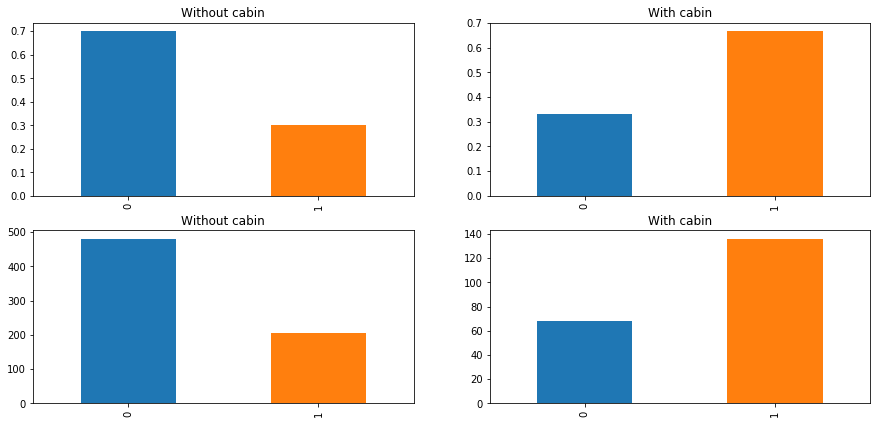

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(15,7))

_ = train_df[train_df['Cabin is present'] == 0]['Survived'].value_counts(normalize=True, sort=False).plot(kind='bar', title='Without cabin', ax=ax[0][0])
_ = train_df[train_df['Cabin is present'] == 1]['Survived'].value_counts(normalize=True, sort=False).plot(kind='bar', title='With cabin', ax=ax[0][1])

_ = train_df[train_df['Cabin is present'] == 0]['Survived'].value_counts(sort=False).plot(kind='bar', title='Without cabin', ax=ax[1][0])
_ = train_df[train_df['Cabin is present'] == 1]['Survived'].value_counts(sort=False).plot(kind='bar', title='With cabin', ax=ax[1][1])

If cabin is present a passenger very likely to has survived

In [26]:
def age_category(f_df, df):
    def unify(age):
        if age < 10:
            return 'Child'
        elif age < 18:
            return 'Teenager'
        elif age < 50:
            return 'Adult'
        else:
            return 'Retiree'
        
    f_df['Age category'] = f_df['Age'].map(unify)

In [27]:
age_category(train_df, train_df)

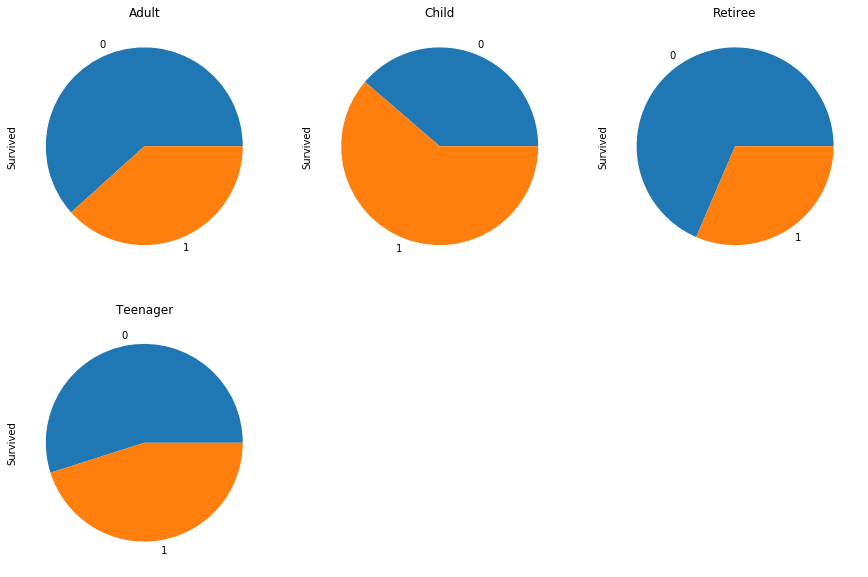

In [28]:
drow_pie('Age category')

In [29]:
all_husbants = husbands['Surname'].unique()

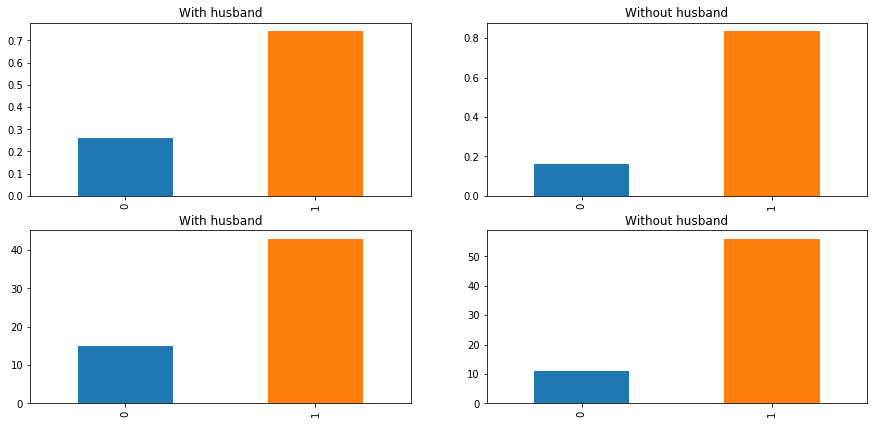

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(15,7))

_ = wifes[wifes['Surname'].isin(all_husbants)]['Survived'].value_counts(normalize=True, sort=False).plot(kind='bar', title='With husband', ax=ax[0][0])
_ = wifes[wifes['Surname'].isin(all_husbants) == False]['Survived'].value_counts(normalize=True, sort=False).plot(kind='bar', title='Without husband', ax=ax[0][1])

_ = wifes[wifes['Surname'].isin(all_husbants)]['Survived'].value_counts(sort=False).plot(kind='bar', title='With husband', ax=ax[1][0])
_ = wifes[wifes['Surname'].isin(all_husbants) == False]['Survived'].value_counts(sort=False).plot(kind='bar', title='Without husband', ax=ax[1][1])

# Feature engineering

In [31]:
def ticket_number(f_df, df):
    pattern = re.compile('\d*$')
    def extract_number(ticket):
        finder = pattern.search(ticket.strip())
        if finder and finder.group():
            return finder.group()
        else:
            return '0'

    f_df['Ticket number'] = df['Ticket'].map(extract_number)

In [32]:
titul(test_df, test_df)
surname(test_df, test_df)
ticket_number(test_df, test_df)

ticket_number(train_df, train_df)

In [33]:
wifes_test = test_df[test_df['Titul'] == 'Mrs']
husbands_test = test_df[test_df['Titul'] == 'Mr']
children_test = test_df[test_df['Age'] < 16]

In [34]:
wifes_test.shape, husbands_test.shape, children_test.shape

((72, 13), (240, 13), (32, 13))

In [35]:
wifes_test_names = wifes_test['Surname'].unique()
husbands_test_names = husbands_test['Surname'].unique()
children_test_names = children_test['Surname'].unique()

In [36]:
wifes[wifes['Surname'].isin(husbands_test_names)].shape, wifes[wifes['Surname'].isin(children_test_names)].shape

((30, 13), (19, 13))

In [37]:
husbands[husbands['Surname'].isin(wifes_test_names)].shape

(41, 13)

In [38]:
children[children['Surname'].isin(wifes_test_names)].shape

(13, 13)

Seems like some families are separated between train and test datasets

In [39]:
surname_counts = train_df['Surname'].append(test_df['Surname']).value_counts()

surname_counts.to_csv(PATH_TO_DATA + 'surname_counts.csv')

In [40]:
ticket_numbers_counts = train_df['Ticket number'].append(test_df['Ticket number']).value_counts()

ticket_numbers_counts.to_csv(PATH_TO_DATA + 'ticket_numbers_counts.csv')

List of features to extract:
 * Pclass
 * Surname
 * Titul
 * For wifes if child survived
 * For wifes if husband susvived
 * For husbands if wife died
 * For child if mather survived
 * Sex
 * Age
 * Is child
 * Count of relatives on board (?)
 * Ticket number
 * Fare (log)
 * Deck
 * Cabin number
 * Is cabin present
 * Embarked (?)
 * Is alone

In [41]:
def copy_features(f_df, df):
    f_df['Pclass'] = df['Pclass']
    f_df['Sex'] = df['Sex'].map(lambda s: 1 if s == 'male' else 0)
    f_df['Embarked'] = df['Embarked'].fillna('S')
    f_df['Fare'] = df['Fare'].fillna(df['Fare'].mean()).map(lambda x: 0 if x == 0 else np.log(x))

In [42]:
def name_features(f_df, df):
    titul(f_df, df)
    surname(f_df, df)
    
    husbands_df = pd.read_csv(PATH_TO_DATA + 'husbands.csv', index_col='PassengerId')
    wifes_df = pd.read_csv(PATH_TO_DATA + 'wifes.csv', index_col='PassengerId')
    children_df = pd.read_csv(PATH_TO_DATA + 'children.csv', index_col='PassengerId')
    surname_counts_df = pd.read_csv(PATH_TO_DATA + 'surname_counts.csv', header=None, index_col=0)[1]
    
    wifes_died = wifes_df[wifes_df['Survived'] == 0]['Surname'].unique()
    wifes_survived = wifes_df[wifes_df['Survived'] == 1]['Surname'].unique()

    husbands_died = husbands_df[husbands_df['Survived'] == 0]['Surname'].unique()
    husbands_survived = husbands_df[husbands_df['Survived'] == 1]['Surname'].unique()
    
    children_died = children_df[children_df['Survived'] == 0]['Surname'].unique()
    children_survived = children_df[children_df['Survived'] == 1]['Surname'].unique()
    
    def if_survived(surname, survived, died):
        if surname in survived:
            return 'Survived'
        elif surname in died:
            return 'Died'
        else:
            return 'Unknown'
    
    # For wifes if child survived
    f_df['Child survived'] = 'Unknown'
    f_df.loc[f_df['Titul'] == 'Mrs', 'Child survived'] = f_df[f_df['Titul'] == 'Mrs']['Surname'].map(lambda x: if_survived(x, children_survived, children_died))
    
    # For wifes if husband susvived
    f_df['Husband survived'] = 0
    f_df.loc[f_df['Titul'] == 'Mrs', 'Husband survived'] = f_df[f_df['Titul'] == 'Mrs']['Surname'].map(lambda x: 1 if x in husbands_survived else 0)
    
    # For husbands if wife died
    f_df['Wife died'] = 0
    f_df.loc[f_df['Titul'] == 'Mr', 'Wife died'] = f_df[f_df['Titul'] == 'Mr']['Surname'].map(lambda x: 1 if x in wifes_died else 0)
    
    # For child if mather survived
    f_df['Mather died'] = 0
    f_df.loc[df['Age'] < 16, 'Mather died'] = f_df[df['Age'] < 16]['Surname'].map(lambda x: 1 if x in wifes_died else 0)

In [43]:
def age_features(f_df, df):
    age_means = pd.read_csv(PATH_TO_DATA + 'age_means.csv', header=None, index_col=0)[1]
    f_df['Age'] = df['Age']
    f_df.loc[f_df['Age'].isnull(), 'Age'] = f_df[f_df['Age'].isnull()].apply(lambda x: age_means[x['Titul']], axis=1)
    
    f_df['Is child'] = f_df['Age'].map(lambda x: 1 if x < 16 else 0)

In [44]:
def relatives_count(f_df, df):
    f_df['Relatives count'] = df['SibSp'] + df['Parch']

In [45]:
def cabin_features(f_df, df):
    df['Cabin'].fillna('U0', inplace=True)
    
    pattern = re.compile('\d*$')
    def extract_number(cabin):
        finder = pattern.search(cabin.strip())
        return finder.group() if finder and finder.group() else '0'

    f_df['Cabin number'] = df['Cabin'].map(extract_number)
    f_df['Deck']= df['Cabin'].map(lambda c: c[0])
    f_df['Is cabin present'] = df['Cabin'].map(lambda c: 0 if c == 'U0' else 1)

In [46]:
def is_alone(f_df, df):
    surname_counts_df = pd.read_csv(PATH_TO_DATA + 'surname_counts.csv', header=None, index_col=0)[1]
    ticket_numbers_counts_df = pd.read_csv(PATH_TO_DATA + 'ticket_numbers_counts.csv', header=None, dtype={0: np.str_}).set_index(0)[1]
    
    def alone(row):
        if surname_counts_df[row['Surname']] == 1 and ticket_numbers_counts_df[row['Ticket number']] == 1 and row['Relatives count'] == 0:
            return 1
        else:
            return 0
    
    f_df['Is alone'] = f_df.apply(alone, axis=1)

In [47]:
def convert_to_featire_df(df):
    feature_df = pd.DataFrame(index=df.index.values)
    
    copy_features(feature_df, df)
    name_features(feature_df, df)
    age_features(feature_df, df)
    relatives_count(feature_df, df)
    cabin_features(feature_df, df)
    ticket_number(feature_df, df)
    is_alone(feature_df, df)
    
    surname_counts_df = pd.read_csv(PATH_TO_DATA + 'surname_counts.csv', header=None, index_col=0)[1]
    ticket_numbers_counts_df = pd.read_csv(PATH_TO_DATA + 'ticket_numbers_counts.csv', header=None, dtype={0: np.str_}).set_index(0)[1]
    
    feature_df['Surname'].apply(lambda x: x if surname_counts_df[x] > 1 else 'Other')
    feature_df['Ticket number'].apply(lambda x: x if ticket_numbers_counts_df[x] > 1 else 'Other')
    
    return feature_df

In [48]:
train_feature_df = convert_to_featire_df(train_df)
test_feature_df = convert_to_featire_df(test_df)

In [49]:
train_feature_df.to_csv(PATH_TO_DATA + 'train_features.csv', index_label='PassengerId')
test_feature_df.to_csv(PATH_TO_DATA + 'test_features.csv', index_label='PassengerId')

# Objects visualisation

In [50]:
train_feature_df.head()

,Pclass,Sex,Embarked,Fare,Titul,Surname,Child survived,Husband survived,Wife died,Mather died,Age,Is child,Relatives count,Cabin number,Deck,Is cabin present,Ticket number,Is alone
1,3,1,S,1.981001,Mr,Braund,Unknown,0,0,0,22.0,0,1,0,U,0,21171,0
2,1,0,C,4.266662,Mrs,Cumings,Unknown,0,0,0,38.0,0,1,85,C,1,17599,0
3,3,0,S,2.070022,Miss,Heikkinen,Unknown,0,0,0,26.0,0,0,0,U,0,3101282,1
4,1,0,S,3.972177,Mrs,Futrelle,Unknown,0,0,0,35.0,0,1,123,C,1,113803,0
5,3,1,S,2.085672,Mr,Allen,Unknown,0,0,0,35.0,0,0,0,U,0,373450,0


In [51]:
num_cols = {'Fare', 'Age', 'Relatives count'}
cat_cols = {'Pclass', 'Sex', 'Embarked', 'Titul', 'Surname', 'Child survived', 'Husband survived', 'Is alone',
           'Wife died', 'Mather died', 'Is child', 'Cabin number', 'Deck', 'Is cabin present', 'Ticket number'}


def create_f_transformer(names):
    ids = np.array([(c in names) for c in train_feature_df.columns], dtype=bool)
    return FunctionTransformer(lambda x: x[:, ids], validate=False)

num_features = make_pipeline(create_f_transformer(num_cols), StandardScaler(with_mean=0))
cat_features = make_pipeline(create_f_transformer(cat_cols), OneHotEncoder(handle_unknown='ignore'))

pipe = make_pipeline(FeatureUnion([
    ('numbers', num_features),
    ('categories', cat_features)
]))

In [52]:
X = train_feature_df.values
y = train_df['Survived'].values

C:\Users\kipil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\kipil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


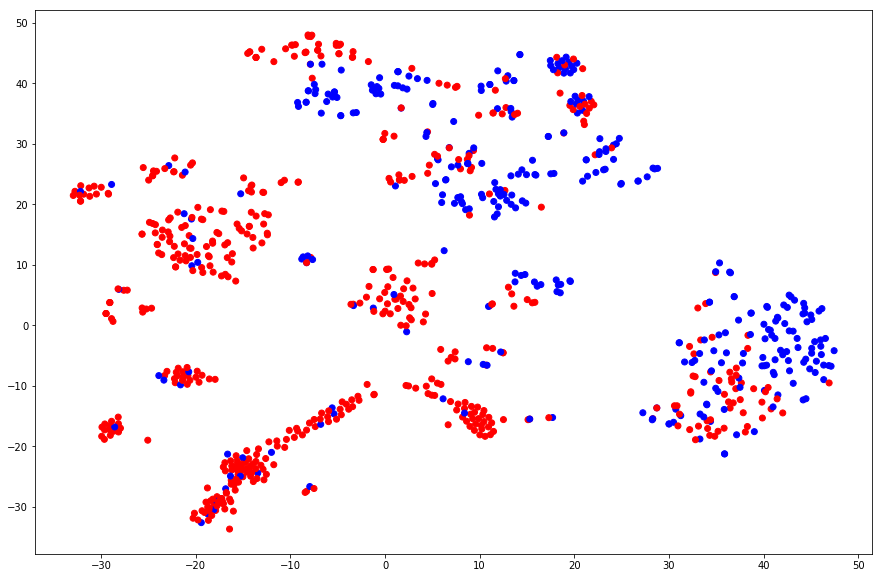

In [53]:
tmp = pipe.fit_transform(X)
X_2d = TSNE(n_components=2).fit_transform(tmp.toarray())

colors = ["r" if s == 0 else "b" for s in y]
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
_ = ax.scatter(X_2d[:, 0:1], X_2d[:, 1], c=colors)